In this project, we will carry out data analysis of a Credit Risk Dataset. We will perform a comprehensive anaylsis including SQL Data Extraction and Insights along with Predictive Modelling and Deployment.

# SQL Data Extraction

## Downloading the dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/credit-risk-dataset


## Setting up the Database

In [2]:
import pandas as pd
import sqlite3

# Load dataset
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")  

# Create a SQLite connection
conn = sqlite3.connect(':memory:')  # Uses an in-memory database
df.to_sql('credit_risk', conn, index=False, if_exists='replace')  # Load data into SQL

32581

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


#### As we can see, the dataset contains the target variable of loan_status along with the demographic data about the borrower and his/her credit history.

## SQL Query Insights

### Question 1 : What is the average loan amount and interest rate for each loan category?

In [4]:
query = """
SELECT 
    AVG(loan_amnt) AS "Average Loan", 
    AVG(loan_int_rate) AS "Average Interest Rate", 
    loan_grade AS "Category"
FROM credit_risk
GROUP BY loan_grade;
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

   Average Loan  Average Interest Rate Category
0   8539.273453               7.327651        A
1   9995.483686              10.995555        B
2   9213.862651              13.463542        C
3  10849.241589              15.361448        D
4  12915.845436              17.009455        E
5  14717.323651              18.609159        F
6  17195.703125              20.251525        G


**Average interest rate increase as we go from the best to worst loan category. Interestingly, the average loan amount also shows an increasing pattern across the categories.**

### Question 2 : Find the top 10 borrowers with the highest credit history length who have defaulted.

In [5]:
query = """
SELECT *
FROM credit_risk
WHERE loan_status = 1
ORDER BY cb_person_cred_hist_length DESC
LIMIT 10;
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

   person_age  person_income person_home_ownership  person_emp_length  \
0          55          50000                  RENT                2.0   
1          51          37200                  RENT                4.0   
2          53          34000              MORTGAGE                0.0   
3          55          34000                  RENT                0.0   
4          52         163000              MORTGAGE                9.0   
5          62          76500                  RENT                0.0   
6          54          33600                  RENT                0.0   
7          66          40000                  RENT                2.0   
8          52          36000                  RENT                8.0   
9          55          78000              MORTGAGE                2.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    HOMEIMPROVEMENT          A      20000           7.51            1   
1            MEDICAL          B       3000      

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


**Highest credit history length is around 30 months. Interestingly, all the people who have defaulted have age on the higher side (50+). Also, most them did not have a prior default.**

### Question 3 : Find the top 5 borrowers with the highest loan amounts within each loan intent category

In [6]:
query = """
SELECT *
FROM (
SELECT *, ROW_NUMBER() OVER (PARTITION BY loan_intent ORDER BY loan_amnt DESC) AS rank
FROM credit_risk)
ranked
WHERE rank<=5;
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

    person_age  person_income person_home_ownership  person_emp_length  \
0           23         113000                  RENT                8.0   
1           24          74000                   OWN                8.0   
2           24          95000              MORTGAGE                3.0   
3           25          96000              MORTGAGE                5.0   
4           23         112800              MORTGAGE                3.0   
5           26          77100                  RENT                8.0   
6           26         108160                  RENT                4.0   
7           23         115000                  RENT                2.0   
8           23         120000                  RENT                0.0   
9           26         213000              MORTGAGE                6.0   
10          24          72400              MORTGAGE                4.0   
11          24          96000              MORTGAGE                8.0   
12          25         100505         

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


**Top 5 borrowers in each loan intent category are young people (age < 30) with loan amount of 35000.** 

### Question 4 : List all borrowers whose loan amount is higher than the average loan amount of defaulted borrowers

In [7]:
query = """
SELECT *
FROM credit_risk
WHERE loan_amnt> (
   SELECT AVG(loan_amnt)
   FROM credit_risk
   WHERE loan_status = 1);
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              23          65500                  RENT                4.0   
2              24          54400                  RENT                8.0   
3              26          77100                  RENT                8.0   
4              24          78956                  RENT                5.0   
...           ...            ...                   ...                ...   
10633          60          45600                  RENT                1.0   
10634          52          65004                  RENT                4.0   
10635          54         120000              MORTGAGE                4.0   
10636          65          76000                  RENT                3.0   
10637          56         150000              MORTGAGE                5.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \

**10638 (around 1/3 of the complete dataset) borrowers have loan amount higher than the average loan amount of defaulters.** 

### Question 5 : Categorize borrowers as Low Risk, Medium Risk or High Risk based on their loan percent income.

In [8]:
query = """
SELECT 
    COUNT(loan_percent_income) AS "Total Count",
    MIN(loan_percent_income) AS "Minimum Rate",
    MAX(loan_percent_income) AS "Maximum Rate",
    AVG(loan_percent_income) AS "Average Rate",
    sqrt(AVG(loan_percent_income * loan_percent_income) - AVG(loan_percent_income) * AVG(loan_percent_income)) AS Standard_Deviation
FROM credit_risk;
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

   Total Count  Minimum Rate  Maximum Rate  Average Rate  Standard_Deviation
0        32581           0.0          0.83      0.170203             0.10678


In [9]:
query = """
SELECT 
    *, 
    CASE
        WHEN loan_percent_income > 0.5 THEN 'High'
        WHEN loan_percent_income BETWEEN 0.15 AND 0.5 THEN 'Medium'
        ELSE 'Low'
    END AS "Borrower Risk"
    
FROM credit_risk;
"""

# Run SQL query
result = pd.read_sql_query(query, conn)
print(result)

       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \

**We have categorized all the borrowers into the three risk categories of "Low", "Medium" and "High" based on the loan amount they have borrowed as the percentage of their income. The extracted dataset can be now used to generate further insights.**

# Predictive Modelling using Python

We will now carry out predictive modelling on the dataset to predict the defaulters using their demographic and loan specification data using **Logistic regression and the XGBoost Algorithm.**

## Exploratory Data Analysis

### Data Cleaning

In [10]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import missingno as msno

<Axes: >

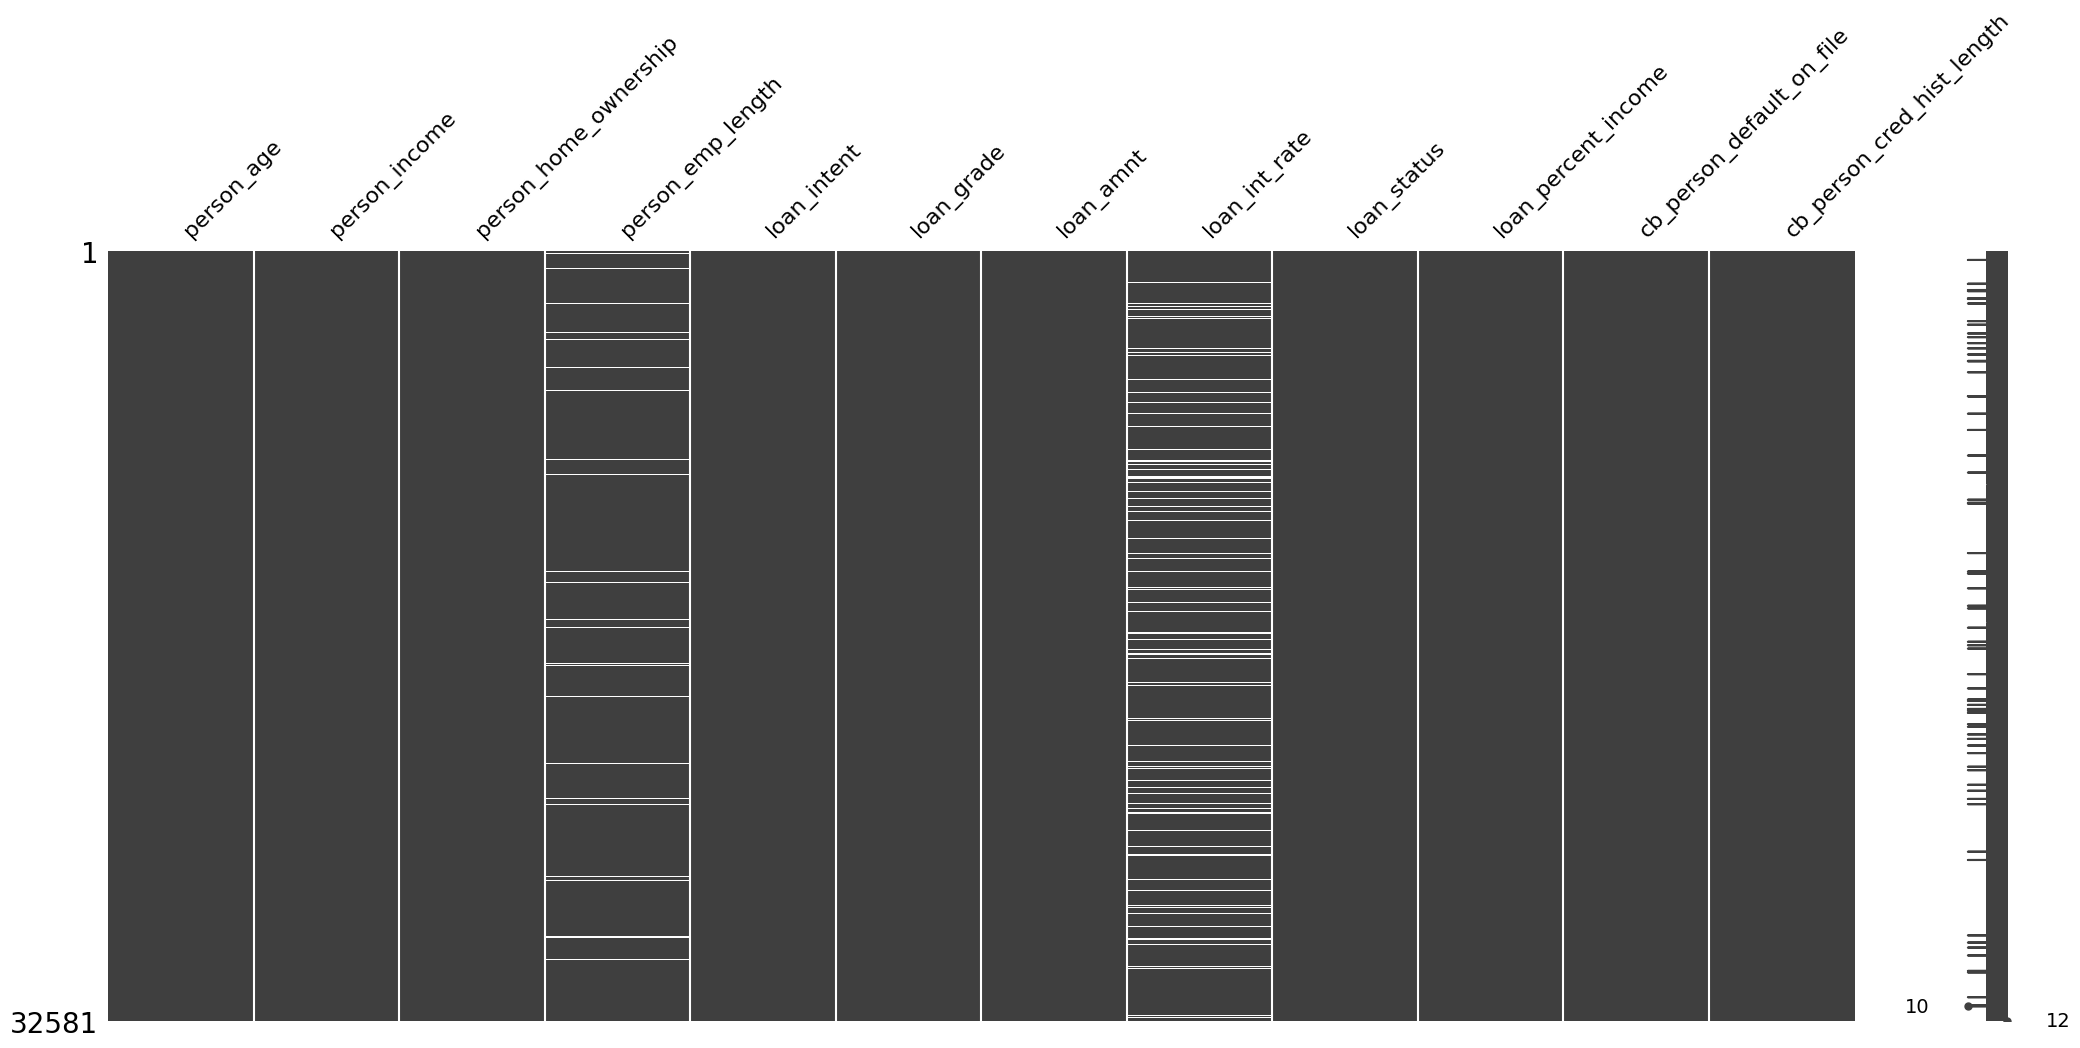

In [12]:
msno.matrix(df)

Two colummns: "person_emp_length" and "loan_int_rate" have missing values. "person_emp_length" has only few missing values (less than 100) in a dataset of more than 32000 data points. Therefore, we can easily remove those rows. Dealing with the other column requires some data imputation technique.

As seen in the SQL analysis above, the interest rates of the loan depend strongly on the loan grade. To handle missing values, we will impute them with the median of the interest rate value of each loan grade as applicable.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [14]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [15]:
df = df.dropna(subset=['person_emp_length'])

df['loan_int_rate'] = df['loan_int_rate'].fillna(
    df.groupby('loan_grade')['loan_int_rate'].transform('median')
)

<Axes: >

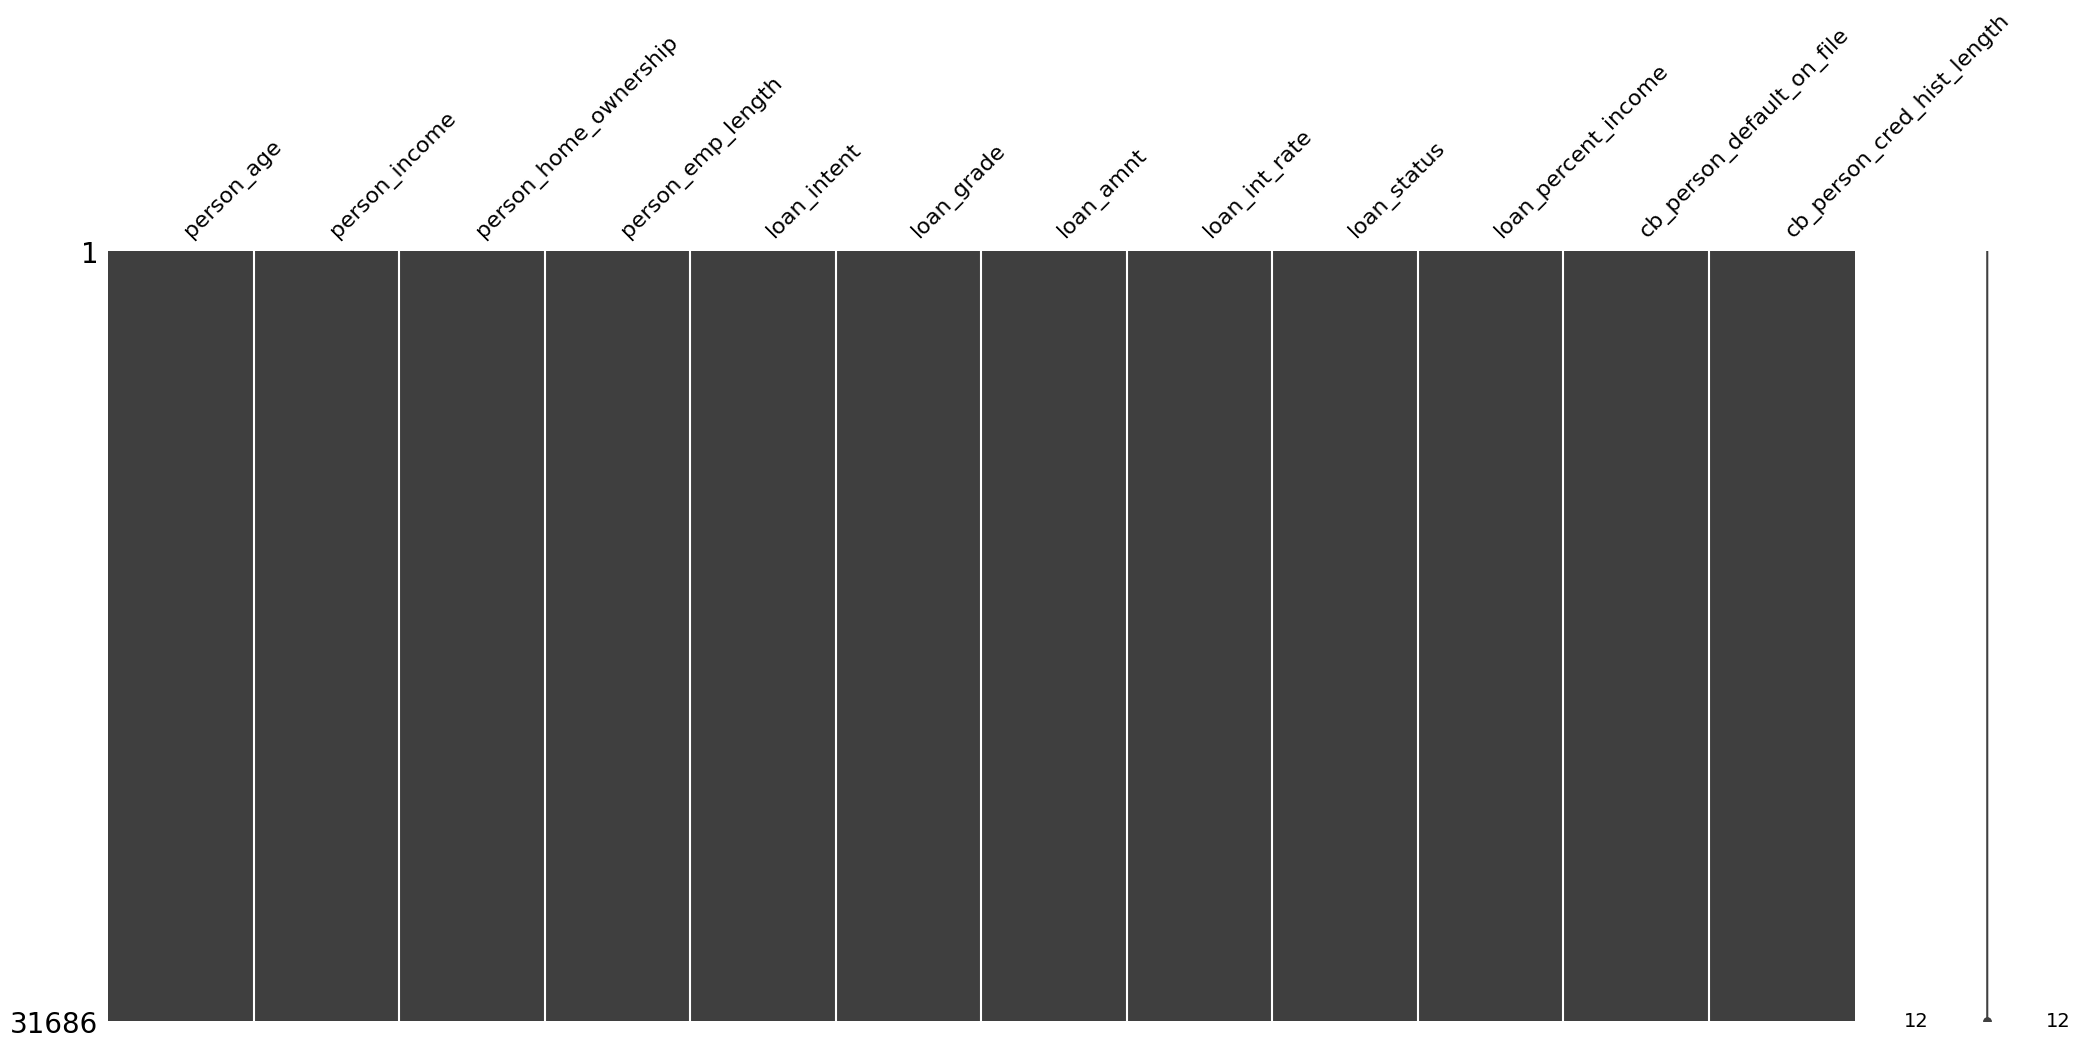

In [16]:
msno.matrix(df)

In [17]:
df.shape

(31686, 12)

In [18]:
df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [19]:
df['loan_intent'].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [20]:
df['loan_grade'].unique()

array(['D', 'B', 'C', 'A', 'E', 'F', 'G'], dtype=object)

In [21]:
df['loan_status'].unique()

array([1, 0])

In [22]:
df['cb_person_default_on_file'].unique()

array(['Y', 'N'], dtype=object)

In [23]:
# Columns you want to encode
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']  

# Create dummies
df_dummies = pd.get_dummies(df[categorical_cols], drop_first=True)


print("Shape of the DataFrame after dummies:", df_dummies.shape)

print(df.index.equals(df_dummies.index))

# Drop original categorical columns and add dummies
df = pd.concat([df.drop(columns=categorical_cols), df_dummies], axis=1)

print("Shape of the DataFrame after concatenation:", df.shape)

Shape of the DataFrame after dummies: (31686, 15)
True
Shape of the DataFrame after concatenation: (31686, 23)


In [24]:
from sklearn.preprocessing import StandardScaler
# Columns you want to scale
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']  

# Standardize selected numerical columns
scaler = StandardScaler()
df_scaled_part = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df.index)

print("Shape of the DataFrame after scaling:", df_scaled_part.shape)
print(df.index.equals(df_scaled_part.index))

# Drop original numerical columns and add scaled ones
df = pd.concat([df.drop(columns=numerical_cols), df_scaled_part], axis=1)

print("Shape of the DataFrame after concatenation:", df.shape)

Shape of the DataFrame after scaling: (31686, 7)
True
Shape of the DataFrame after concatenation: (31686, 23)


In [25]:
df.describe()

,loan_status,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,31686.000000,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04
mean,0.215426,-1.722202e-16,4.305504e-17,1.435168e-17,9.687384e-17,2.359057e-16,1.542806e-16,-1.148134e-16
std,0.411124,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,0.000000,-1.218094e+00,-1.004254e+00,-1.156213e+00,-1.445889e+00,-1.755824e+00,-1.595672e+00,-9.380698e-01
25%,0.000000,-7.464096e-01,-4.372336e-01,-6.734201e-01,-7.356763e-01,-9.812599e-01,-7.489728e-01,-6.918131e-01
50%,0.000000,-2.747251e-01,-1.712720e-01,-1.906274e-01,-2.622009e-01,-1.617863e-02,-1.845065e-01,-4.455564e-01
75%,0.000000,3.541877e-01,2.131813e-01,5.335617e-01,4.480122e-01,7.615082e-01,5.681153e-01,5.394706e-01
max,1.000000,1.827820e+01,9.504500e+01,2.853554e+01,3.999078e+00,3.803544e+00,6.212778e+00,5.957119e+00


<Axes: >

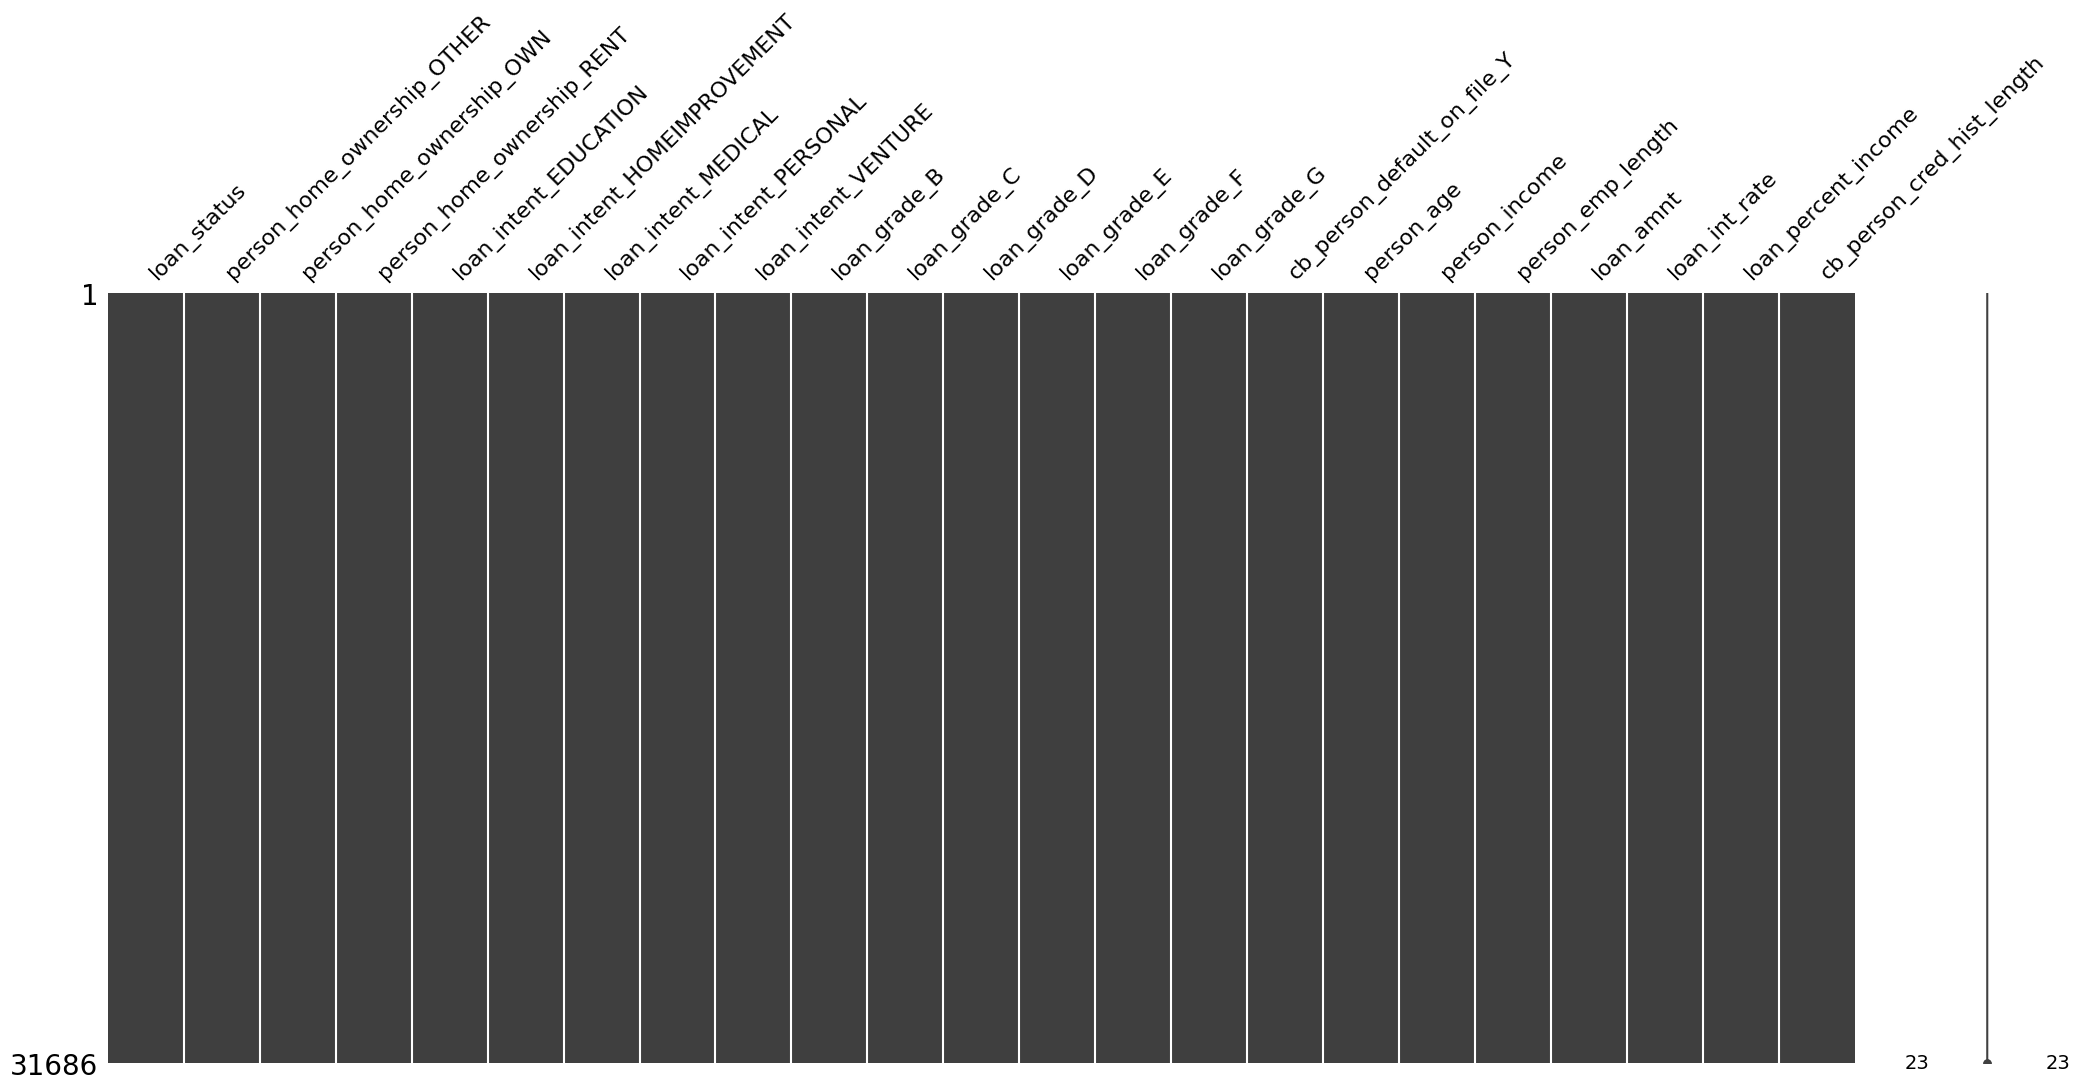

In [26]:
msno.matrix(df)

In [27]:
df.replace({True: 1, False: 0}, inplace=True)

<ipython-input-27-e27b85c07cb6>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [28]:
df.describe()

,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,31686.000000,...,31686.000000,31686.000000,31686.000000,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04,3.168600e+04
mean,0.215426,0.003377,0.076059,0.507353,0.198510,0.110774,0.186107,0.169444,0.175346,0.321467,...,0.007448,0.002020,0.177649,-1.722202e-16,4.305504e-17,1.435168e-17,9.687384e-17,2.359057e-16,1.542806e-16,-1.148134e-16
std,0.411124,0.058014,0.265096,0.499954,0.398885,0.313858,0.389199,0.375149,0.380268,0.467047,...,0.085982,0.044898,0.382223,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.218094e+00,-1.004254e+00,-1.156213e+00,-1.445889e+00,-1.755824e+00,-1.595672e+00,-9.380698e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.464096e-01,-4.372336e-01,-6.734201e-01,-7.356763e-01,-9.812599e-01,-7.489728e-01,-6.918131e-01
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-2.747251e-01,-1.712720e-01,-1.906274e-01,-2.622009e-01,-1.617863e-02,-1.845065e-01,-4.455564e-01
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,3.541877e-01,2.131813e-01,5.335617e-01,4.480122e-01,7.615082e-01,5.681153e-01,5.394706e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.827820e+01,9.504500e+01,2.853554e+01,3.999078e+00,3.803544e+00,6.212778e+00,5.957119e+00


<Axes: >

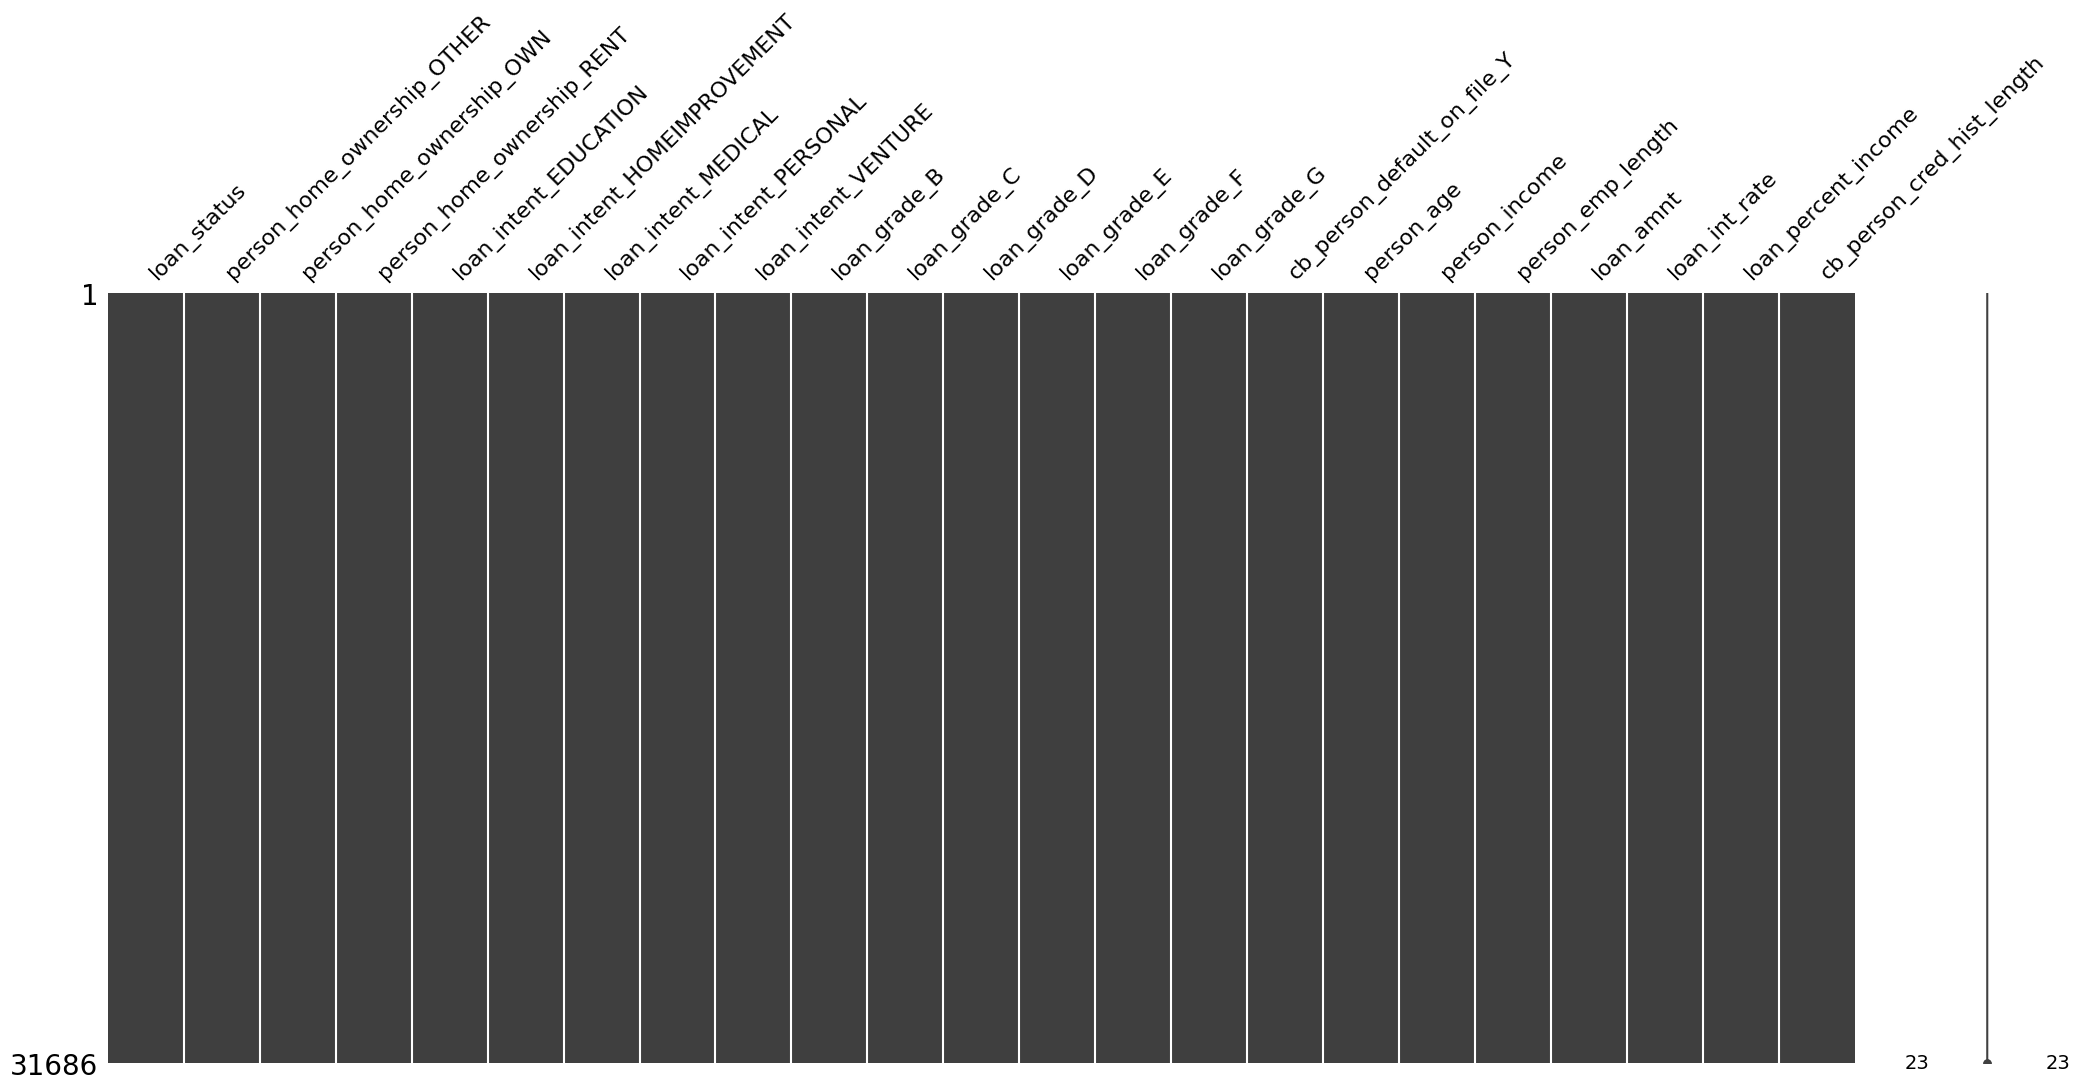

In [29]:
msno.matrix(df)

In [30]:
df.shape

(31686, 23)

### Data Preprocessing

In [31]:
df['loan_status'].value_counts()

loan_status
0    24860
1     6826
Name: count, dtype: int64

In [32]:
from sklearn.model_selection import train_test_split

# Input and Output Variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']  # Target variable (1 = default, 0 = no default)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [33]:
from sklearn.utils import resample

df_train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
default_0 = df_train[df_train['loan_status'] == 0]
default_1 = df_train[df_train['loan_status'] == 1]

# Upsample minority class
default_1_upsampled = resample(
    default_1,
    replace=True,                 # Sample with replacement
    n_samples=len(default_0),       # Match number of majority class
    random_state=25               # For reproducibility
)

# Combine majority and upsampled minority
df_train_oversampled = pd.concat([default_0, default_1_upsampled])

# Shuffle the dataset
df_train_oversampled = df_train_oversampled.sample(frac=1, random_state=25).reset_index(drop=True)

# Check the class distribution
print(df_train_oversampled['loan_status'].value_counts())

loan_status
0    17434
1    17434
Name: count, dtype: int64


In [34]:
df_train_oversampled.head()

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_G,cb_person_default_on_file_Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,0,0,0,0,0,0,1,0,0,0,...,0,0,-0.746410,1.046164,0.050769,0.842575,-1.265475,-0.560817,-0.938070,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0.196959,0.293276,-0.673420,0.053449,-0.987506,-0.466740,1.031984,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,-0.431953,-0.211848,0.050769,2.420826,1.454868,2.167437,-0.445556,1
3,0,0,1,0,0,0,0,1,0,1,...,0,1,0.983100,-0.427574,-0.673420,0.558490,0.761508,1.508892,0.046957,1
4,0,0,1,1,0,0,0,0,0,1,...,0,0,-0.903638,-0.587763,-0.673420,0.526925,0.645948,2.449670,-0.691813,1


In [35]:
X_train = df_train_oversampled.drop(columns=['loan_status'])
y_train = df_train_oversampled['loan_status']  # Target variable (1 = default, 0 = no default)

In [36]:
X_train.head()

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,...,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,-0.746410,1.046164,0.050769,0.842575,-1.265475,-0.560817,-0.938070
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0.196959,0.293276,-0.673420,0.053449,-0.987506,-0.466740,1.031984
2,0,0,0,0,0,1,0,0,0,0,...,0,0,1,-0.431953,-0.211848,0.050769,2.420826,1.454868,2.167437,-0.445556
3,0,0,1,0,0,0,0,1,0,1,...,0,0,1,0.983100,-0.427574,-0.673420,0.558490,0.761508,1.508892,0.046957
4,0,0,1,1,0,0,0,0,0,1,...,0,0,0,-0.903638,-0.587763,-0.673420,0.526925,0.645948,2.449670,-0.691813


## Model Training

### Using LogisticRegression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

# Train the PD model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


### Using XGBoost

In [38]:
import xgboost as xgb

# Train XGBoost model
model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


**We see that XGBoost performs much better than LogisticRegression in predicting default**.